# Demo-0: Bloch Equation. 

In [8]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

from pprint import pprint 


The first step is to write down the Bloch equation in its matrix representation:

$$
\frac{\mathrm{d}}{\mathrm{d} t} \mathbf{M} = \mathbf{A} \cdot \mathbf{M}
$$

where the magnetization vector reads

$$
\mathbf{M} = 
    \begin{bmatrix}
        M_x \\
        M_y \\
        M_z  
    \end{bmatrix}
$$
and the transition matrix reads
$$
\mathbf{A} = 
    \begin{bmatrix}
        -R_2            & \Delta\omega_z    & -\gamma B_{1,y} \\
        -\Delta\omega_z & -R_2              &  \gamma B_{1,x} \\
         \gamma B_{1,y} & -\gamma B_{1,x}   & -R_1
    \end{bmatrix}
$$


In order to add the phenomenological thermalization to the lattice, we have two ways:

Either we can add an additional term $\mathbf{R}$ to the Bloch equation such that:

$$
\frac{\mathrm{d}}{\mathrm{d} t} \mathbf{M} = \mathbf{A} \cdot \mathbf{M} + \mathbf{R}
$$

Or we can extend the dimension of $\mathbf{M}$, including the magnetization at thermal equilibrium:


$$
\mathbf{M} = 
    \begin{bmatrix}
        M_x \\
        M_y \\
        M_z \\
        M_{eq}
    \end{bmatrix}
$$

Consequently, the transiton matrix also expands its dimension:

$$
\mathbf{A} = 
    \begin{bmatrix}
        -R_2            &  \Delta\omega_z   & -\gamma B_{1,y}   & 0     \\
        -\Delta\omega_z & -R_2              &  \gamma B_{1,x}   & 0     \\
         \gamma B_{1,y} & -\gamma B_{1,x}   & -R_1              & R_1   \\
         0              &  0                &  0                & 0
    \end{bmatrix}
$$

As for the $M_{eq}$, we can either assign it as unity, following the convention in the MRI community, or assign the value of thermal polarization as in the community of NMR or condensed phase physics.

We choose the second way to construct a homogeneous differential matrix equation, seeing the convenient solution with matrix exponential:

$$
\mathbf{M} (t=\tau) = \exp (\mathbf{A} \cdot \tau) \mathbf{M} (t=0)
$$

Now we try to visualize the solution of Bloch eqn.

In the next block we list the parameters that specify the system:

In [9]:
T_1 = 1                     # sec
R_1 = 0 # 1 / T_1           # s^-1
T_2 = 0.05                  # sec
R_2 = 0 # 1 / T_2           # s^-1
deltaOmegaZ = 0             # Hz
omega1Y = 0                 # Hz
omega1X = 250 * 2 * np.pi   # Rad
nSteps = int(1e5)
tau = 0.1                     # sec
dTau = tau/nSteps           # sec


A = np.array([[-R_2, deltaOmegaZ, -omega1Y, 0],[-deltaOmegaZ, -R_2,omega1X,0],[omega1Y, -omega1X, R_1, R_1],[0,0,0,0]])

pprint(A)

M_0T = np.array([[0,0,1,1]])
print(np.shape(M_0T))
M_0 = M_0T.T
print(np.shape(M_0))



array([[    0.        ,     0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,  1570.79632679,     0.        ],
       [    0.        , -1570.79632679,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        ,     0.        ]])
(1, 4)
(4, 1)


We first try Explicit Euler method, from where we can see numerical unstability.

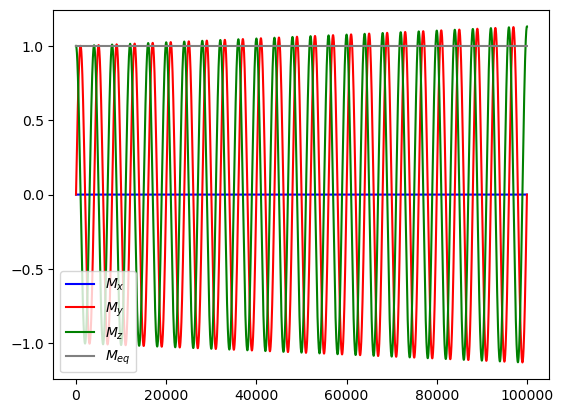

In [10]:
def explictEulerBlochSolve(A, M_0, nbr_steps, dTau):
    A.astype(np.float64)
    M_0.astype(np.float64)

    mTrajList = []
    mTrajList.append(M_0)
    identityMat = np.eye(*np.shape(A), dtype=np.float64)
    
    for i_step in range(nbr_steps):

        M_0 = np.dot((identityMat + dTau * A), M_0)
        mTrajList.append(M_0)

    return np.asarray(mTrajList, dtype=np.float64)

mTrajList = explictEulerBlochSolve(A, M_0, nSteps, dTau)



plt.figure()
plt.plot(mTrajList[:,0], color='blue' ,label='$M_x$')
plt.plot(mTrajList[:,1], color='red'  ,label='$M_y$')
plt.plot(mTrajList[:,2], color='green',label='$M_z$')
plt.plot(mTrajList[:,3], color='grey' ,label='$M_{eq}$')

plt.legend(loc='best')
plt.show()

Now comes Implicit Euler method, which is theoretically more stable.

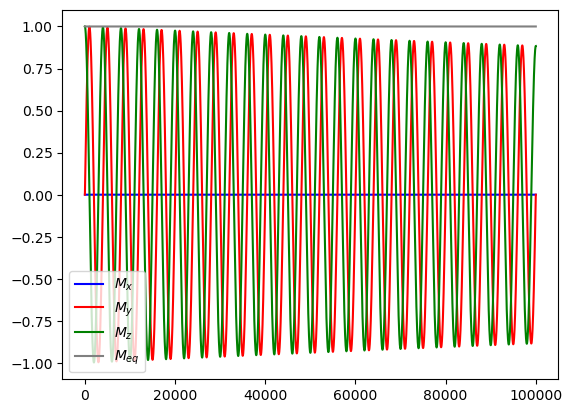

In [11]:
def implictEulerBlochSolve(A, M_0, nbr_steps, dTau):
    A.astype(np.float64)
    M_0.astype(np.float64)

    mTrajList = []
    mTrajList.append(M_0)
    identityMat = np.eye(*np.shape(A), dtype=np.float64)
    
    for i_step in range(nbr_steps):

        M_0 = np.dot(np.linalg.inv(identityMat - dTau * A), M_0)
        mTrajList.append(M_0)

    return np.asarray(mTrajList, dtype=np.float64)

mTrajList = implictEulerBlochSolve(A, M_0, nSteps, dTau)



plt.figure()
plt.plot(mTrajList[:,0], color='blue' ,label='$M_x$')
plt.plot(mTrajList[:,1], color='red'  ,label='$M_y$')
plt.plot(mTrajList[:,2], color='green',label='$M_z$')
plt.plot(mTrajList[:,3], color='grey' ,label='$M_{eq}$')

plt.legend(loc='best')
plt.show()

Both explicit and implicit Euler method use local linear increment to imitate short time kinetics. when the time step is not small enough (in the _infinitisimal_ sense), we introduce systematic numerical error.

In the explicit Euler propagation, the system evolves with $(\mathbf{I} + \mathbf{A}\tau)$, which makes $ \lVert \mathbf{M} \rVert $ ever increasing along with numerical propagation. 

Similarly for the ever decreasing $ \lVert \mathbf{M} \rVert $ in the implicit Euler case with $(\mathbf{I} - \mathbf{A}\tau)^{-1}$.

Finally we use the analytical solution from Lie algebra, which employs $\exp{[\mathbf{A}\tau]}$ that conserves energy.

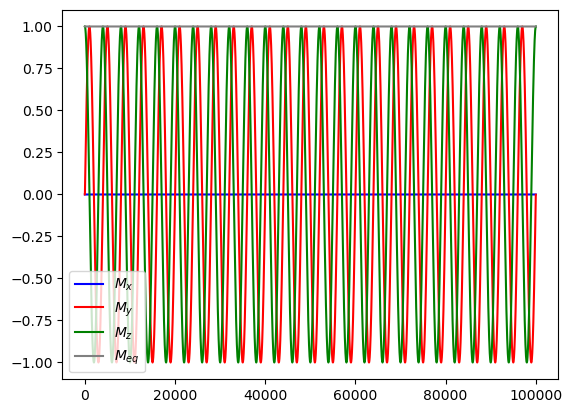

In [12]:
def analyticalSolve0(A, M_0, nbr_steps, dTau):
    A.astype(np.float64)
    M_0.astype(np.float64)

    mTrajList = []
    mTrajList.append(M_0)
    
    for i_step in range(nbr_steps):
        expA = scipy.linalg.expm(A*dTau*i_step)
        mTrajList.append(np.dot(expA, M_0))

    return np.asarray(mTrajList, dtype=np.float64)

mTrajList = analyticalSolve0(A, M_0, nSteps, dTau)



plt.figure()
plt.plot(mTrajList[:,0], color='blue' ,label='$M_x$')
plt.plot(mTrajList[:,1], color='red'  ,label='$M_y$')
plt.plot(mTrajList[:,2], color='green',label='$M_z$')
plt.plot(mTrajList[:,3], color='grey' ,label='$M_{eq}$')

plt.legend(loc='best')
plt.show()

To accelerate the propagation of matrix exponential, we adopt the _propagator recycling_ to accelerate the calculation

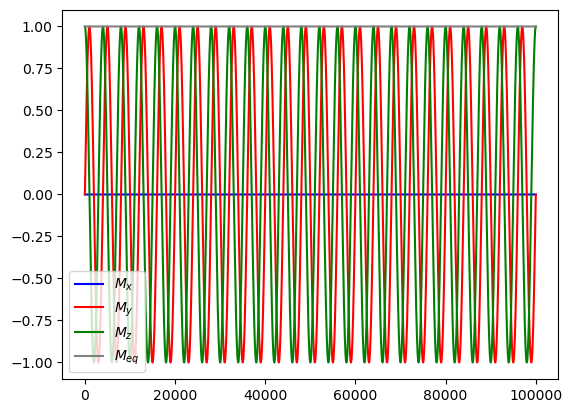

In [13]:
def analyticalBlochSolve(A, M_0, nbr_steps, dTau):
    A.astype(np.float64)
    M_0.astype(np.float64)
    propagator = scipy.linalg.expm(A*dTau)


    mTrajList = []
    mTrajList.append(M_0)
    
    for i_step in range(nbr_steps):
        M_0 = np.dot(propagator, M_0)
        mTrajList.append(M_0)

    return np.asarray(mTrajList, dtype=np.float64)

mTrajList = analyticalBlochSolve(A, M_0, nSteps, dTau)



plt.figure()
plt.plot(mTrajList[:,0], color='blue' ,label='$M_x$')
plt.plot(mTrajList[:,1], color='red'  ,label='$M_y$')
plt.plot(mTrajList[:,2], color='green',label='$M_z$')
plt.plot(mTrajList[:,3], color='grey' ,label='$M_{eq}$')

plt.legend(loc='best')
plt.show()

Now we include excitation offset and phenomenological relaxation

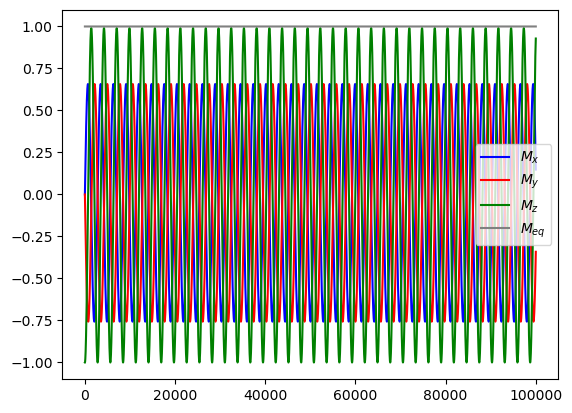

In [14]:
T_1 = 1                     # sec
R_1 = 0 # 1 / T_1           # s^-1
T_2 = 0.05                  # sec
R_2 = 0 # 1 / T_2           # s^-1
deltaOmegaZ = 25 * 2 * np.pi# Hz
omega1Y = 250 * 2 * np.pi   # Hz
omega1X = 250 * 2 * np.pi   # Rad
nSteps = int(1e5)
tau = 0.1                  # sec
dTau = tau/nSteps           # sec


A = np.array([[-R_2, deltaOmegaZ, -omega1Y, 0],[-deltaOmegaZ, -R_2,omega1X,0],[omega1Y, -omega1X, R_1, R_1],[0,0,0,0]])

M_0T = np.array([[0,0,-1,1]])
M_0 = M_0T.T

mTrajList = analyticalBlochSolve(A, M_0, nSteps, dTau)

plt.figure()
plt.plot(mTrajList[:,0], color='blue' ,label='$M_x$')
plt.plot(mTrajList[:,1], color='red'  ,label='$M_y$')
plt.plot(mTrajList[:,2], color='green',label='$M_z$')
plt.plot(mTrajList[:,3], color='grey' ,label='$M_{eq}$')

plt.legend(loc='best')
plt.show()